In [2]:
from pyjstat import pyjstat
import altair as alt, pandas as pd
#_ = alt.renderers.enable('notebook')

## Load asylum applicants data, rename value column and drop unused columns

In [3]:
ds_asyl = pyjstat.Dataset.read('http://ec.europa.eu/eurostat/wdds/rest/data/v2.1/json/en/tps00191?filterNonGeo=1&precision=1')
df_asyl = ds_asyl.write('dataframe').set_index(['time', 'geo', 'asyl_app']).rename(columns={'value': 'asyl_count'}).drop(columns=['unit', 'sex', 'citizen', 'age'])

C:\tools\miniconda3\envs\data\lib\site-packages\pyjstat\pyjstat.py:250: FutureWarning: by argument to sort_index is deprecated, please use .sort_values(by=...)
  dim_label = pd.merge(dim_label, dim_index, on='id').sort_index(by='index')


## Load population data, rename value column and drop unused columns

In [4]:
ds_pop = pyjstat.Dataset.read('http://ec.europa.eu/eurostat/wdds/rest/data/v2.1/json/en/tps00001?filterNonGeo=1&precision=1')
df_pop = ds_pop.write('dataframe').set_index(['time', 'geo']).rename(columns={'value': 'population'}).drop(columns=['indic_de'])

## Load real BIP data, rename value column and drop unused columns

In [5]:
ds_bip = pyjstat.Dataset.read('http://ec.europa.eu/eurostat/wdds/rest/data/v2.1/json/en/sdg_08_10?filterNonGeo=1&precision=1')
df_bip = ds_bip.write('dataframe')
df_bip = df_bip[df_bip.unit == 'Chain linked volumes (2010), euro per capita'].set_index(['time', 'geo']).rename(columns={'value': 'BIP'}).drop(columns=['unit', 'na_item'])

## Join asylum, population and BIP data
Also, simplify name of Germany and convert year to number

In [6]:
df = df_asyl.join(df_pop, on=['time', 'geo'], how='left').join(df_bip, on=['time', 'geo'], how='left')
# the time index is still a string, convert to number and make sure index is sorted
df.index = df.index.set_levels(df.index.levels[0].astype('int'), level=0)
df.index = df.index.set_levels(df.index.levels[1].str.replace('Germany (until 1990 former territory of the FRG)', 'Germany', regex=False), level=1)
df.sort_index(inplace=True)

## Compute number of first time asylum applicants per 1000 population and 1 Mio EUR BIP

In [7]:
df['asyl_count_per_capita_and_bip'] = df.asyl_count / df.population * 1e3 / df.BIP * 1e6
df['asyl_count_per_capita_and_bip_fraction'] = (df.asyl_count_per_capita_and_bip / df.groupby(['time', 'asyl_app']).asyl_count_per_capita_and_bip.sum()).reorder_levels(['time', 'geo', 'asyl_app'])

## Plot data for selected countries after 2014

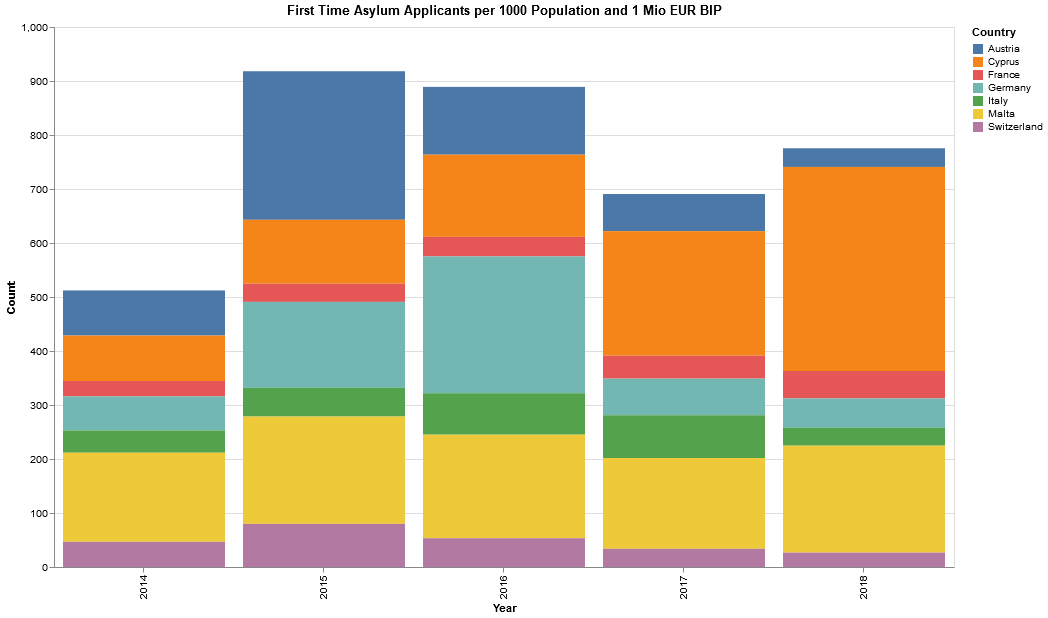

In [8]:
dd = df.loc(axis=0)[
    2014:,
    ['Austria', 'Cyprus', 'France', 'Germany', 'Italy', 'Malta', 'Switzerland'],
    'First time applicant',
]
alt.Chart(dd.reset_index()).mark_bar().encode(
    x=alt.X('time:O', title='Year'),
    y=alt.Y('sum(asyl_count_per_capita_and_bip):Q', title='Count', stack='zero'),
    color=alt.Color('geo:N', title='Country'),
    tooltip=[
        alt.Tooltip('geo', title='Country'),
        alt.Tooltip('sum(asyl_count_per_capita_and_bip)', title='Count', format='.1f'),
        alt.Tooltip('sum(asyl_count_per_capita_and_bip_fraction)', title='Fraction of Total', format='.1%')
    ],
).properties(
    title="First Time Asylum Applicants per 1000 Population and 1 Mio EUR BIP",
    width=900,
    height=540,
)